# PYTORCH TUTORIAL

#### Illustrating some Pytorch basics by implementing a model for MRI tumor classification:
#### 1. Custom dataset class
#### 2. Data-loaders
#### 3. Implementing a basic neural network model
#### 4. Training with data-loaders
#### 5. Basic  evaluation

# Importing the appropriate packages

#### Make sure that the appropriate packages/libraries have been installed and can be imported.  I work with a package manager called Anaconda, with installation instructions here:
#### https://docs.anaconda.com/anaconda/install/
#### On the google collab linux instance that I had started, I installed the following packages with Anaconda from the command line:
#### "conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch"      ~ Installs PyTorch and torchvision

### Importing torch and torchvision: 

In [1]:
import torch
import torchvision

### Additional imports which will be required for this tutorial:

In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as pyplot
%matplotlib inline

# Machine learning Problem for Tutorial

#### Given an a brain MRI image, we want to classify whether a tumor is present or not in the image.  (Data taken from the following kaggle link: https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection). 

#### Images with and without tumors are in the yes and no directories respectively.  We will train a model using images in the train/ directory and then validate it on images from the val/ directory

# Create custom dataset Class 

#### As quoted in the pytorch official tutorial for dataset classes and dataloaders (https://pytorch.org/tutorials/recipes/recipes/custom_dataset_transforms_loader.html), "A significant amount of the effort applied to developing machine learning algorithms is related to data preparation. PyTorch provides many tools to make data loading easy and hopefully, makes your code more readable."
#### In particular, it would be very nice to have some sort of object which handles grabbing data from this directory structure without having to deal with the details everytime

## Barebones Dataset Class 

In [3]:
class TumorDataset(torch.utils.data.Dataset):
    def __init__(self):
        return 0 #Does nothing for now
    def __len__(self):
        return 0 #Do nothing for now
    def __getitem__(self,index):
        return 0 #Do nothing for now

#### We typically need to write three functions (at minimum) to effectively use the Dataset class and interface it with Dataloaders:

## Implementing our dataset class 

### init

In [4]:
class TumorDataset(torch.utils.data.Dataset):
    def __init__(self,root,image_size = (128,128)):
        self.root         = root                      # The root directory of the current training (or validation or testing) dataset that we want to work with
        self.class_names  = os.listdir(self.root)     # Lists the name of folders in our root directory, which in our case, also serves as the class names
        self.image_size   = image_size                # Image size which will be used      
    def __len__(self):
        return 0 #Do nothing for now
    def __getitem__(self,index):
        return 0 #Do nothing for now

#### Whenever we initalize a dataset with our "TumorDataset" class, the code in the initialize function will be called.  In this code, we specify the root directory of the current dataset we want to work with, the list of classes in that root directory (by listing the folder names), and the desired image size

### Initializing the dataset class

In [5]:
path_train_set   = 'brain_tumor_dataset/train/'     #Specify the path to the trainining root directory
dataset_train    = TumorDataset(path_train_set)     #Create the dataset class using the path to the root directory for the training data as an input

#### Printing out properties defined in the initialization function for our class

In [6]:
print('Specified root directory for our dataset class:')
print(dataset_train.root)
print('')

print('List of class names:' )
print(dataset_train.class_names)
print('')

print('Hard-coded Image Size:' )
print(dataset_train.image_size)
print('')

Specified root directory for our dataset class:
brain_tumor_dataset/train/

List of class names:
['yes', 'no']

Hard-coded Image Size:
(128, 128)



#### Trying to get the dataset length and an item 

In [8]:
print("Samples in the dataset: %d" % len(dataset_train))
print("A Sample: {}".format(dataset_train[0]))

Samples in the dataset: 0
A Sample: 0


#### Without implemented functionality, taking the length and indexing a sample in our dataset both return 0

## Implementing the length function for our dataset

In [9]:
class TumorDataset(torch.utils.data.Dataset):
    def __init__(self,root,image_size = (128,128)):
        self.root         = root                      # The root directory of the current training (or validation or testing) dataset that we want to work with
        self.class_names  = os.listdir(self.root)     # Lists the name of folders in our root directory, which in our case, also serve as the class names
        self.image_size   = image_size                # Image size which will be used      
    def __len__(self):
        dataset_size = 0   #Variable which we will use to keep track of dataset length
        
        for cur_class in self.class_names:
            #Recall, that each class relates to a folder which contains our images.  In this for loop, we compute the number of entries in each folder (which corresponds to 
            #the number of samples in each class) and then add it to our total running count of the dataset size.  
            dataset_size += len(os.listdir(self.root + cur_class + '/'))
            
        return dataset_size
    
    def __getitem__(self,index):
        return 0 #Do nothing for now

### Re-intializing our dataset class and returning the length

In [10]:
dataset_train    = TumorDataset(path_train_set)     #Create the dataset class using the path to the root directory for the training data as an input

print("Dataset length: %d" % (len(dataset_train)))

Dataset length: 222


#### Our data-set has 222 total samples.  Note, this length returns the total number of no samples plus the total number of yes samples.  

## Implementing the get item function for the dataset class 

#### We want to return a particular sample of the dataset (which in this case is an image) given an index.  Note, the way I've implemented this below certainly may not be the best or most efficient way

In [11]:
#Quick helper function which will reshape all of our images to the same size
def scale(im, nR, nC):
  nR0 = len(im)     # source number of rows 
  nC0 = len(im[0])  # source number of columns 
  return [[ im[int(nR0 * r / nR)][int(nC0 * c / nC)]  
             for c in range(nC)] for r in range(nR)]

In [12]:
class TumorDataset(torch.utils.data.Dataset):
    def __init__(self,root,size = (128,128)):
        self.root         = root
        self.class_names  = os.listdir(self.root)
        self.size         = size

    def __len__(self):
        dataset_size = 0
        
        for cur_class in self.class_names:
            dataset_size += len(os.listdir(self.root + cur_class + '/'))
            
        return dataset_size
    
    def __getitem__(self,index):
        cur_dataset_size = 0
        class_label      = 0
        image_index      = index
        
        for cur_class in self.class_names:
            #Loop through each of our classes
            
            cur_path       = self.root + cur_class + '/'
            files_in_class = os.listdir(cur_path)
            #Generate a list of .JPG files which correspond to our samples for this particular class
                                       
            cur_dataset_size += len(files_in_class)
            #We assume that our classes are ordered back to back for indexing.  So let's say (for example), that our first class 'no', 
            #has 10 samples, our second class 'yes' has 10 samples, and 'no' comes before 'yes' in ordering.  Then dataset[9] will index the 
            #10th image in the 'no' class, while dataset[10] will index the first image in the 'yes' class.  (recall, python zero indexes).
            #Thus, by keeping track of how much of the total dataset we've traversed, with cur_dataset_size, we can check to see whether index corresponds
            #to the current class
            
            if(index < cur_dataset_size):
                #If index is less than the current data set size, then we know that index should grab an element from this class        
                
                image_index = index - cur_dataset_size
                #Find which element of this class our index corresponds too
                
                image = np.asarray(Image.open(cur_path + files_in_class[image_index]),dtype=np.double)
                #Grab the image and convert it to a numpy array
                
                if len(image.shape) == 3:
                    image = image[:,:,0]
                #Take just the first channel for gray-scale
                
                image = np.expand_dims(scale(image,self.size[0],self.size[1]),axis = 0)
                #Reshape the image to size 1 x 128 x 128
                
                return (image,class_label)
                #Return the image and its associated label as a tuple
            
            class_label += 1

## Using the dataset class to grab and display a couple samples

#### Since we programmed getitem to return a tuple, dataset[ii][0] will return the image for the iith sample in our dataset and dataset[ii][1] will return the associated label

Tumor Example
 image:


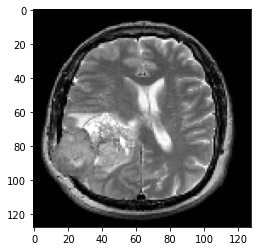

 label: 0
Non-Tumor Example
 image:


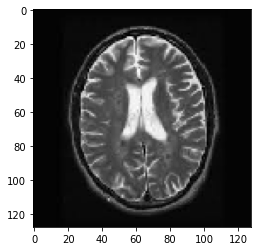

 label: 1


In [13]:
dataset_train    = TumorDataset(path_train_set)
print('Tumor Example')
index = 4
print(' image:')
pyplot.imshow(np.squeeze(dataset_train[index][0]),cmap = 'gray')
pyplot.show()
print(' label: %d' % dataset_train[index][1])

print('Non-Tumor Example')
index = 180
print(' image:')
pyplot.imshow(np.squeeze(dataset_train[index][0]),cmap = 'gray')
pyplot.show()
print(' label: %d' % dataset_train[index][1])

# Incoorporating Dataloaders

#### Given a dataset class, pytorch dataloaders nicely handle the logistics of looping through the dataset given a batch size, as is typical when training neural networks using stochastic gradient descent-esque techniques

In [14]:
batch_size = 4
#Setting our desired batch size

dataloader_training = torch.utils.data.DataLoader(dataset_train,batch_size = batch_size,shuffle=True)
#Initializing our dataloader for the training dataset.  By setting the shuffle flag to True, the dataloader will loop through the entire dataset randomly

#### Below, we loop through the dataset with the dataloader

In [15]:
for i_batch, sampled_batch in enumerate(dataloader_training):
    cur_images = sampled_batch[0] #Grab the images from this batch
    cur_labels = sampled_batch[1] #Grab the corresponding labels from this batch

    print('Batch %d' % (i_batch + 1))
    print('Batch Dimensions:    ', end = '')
    print(cur_images.shape)
    print('Batch Labels:        ', end = '')
    print(cur_labels)

Batch 1
Batch Dimensions:    torch.Size([4, 1, 128, 128])
Batch Labels:        tensor([0, 0, 1, 0])
Batch 2
Batch Dimensions:    torch.Size([4, 1, 128, 128])
Batch Labels:        tensor([1, 0, 0, 0])
Batch 3
Batch Dimensions:    torch.Size([4, 1, 128, 128])
Batch Labels:        tensor([1, 1, 1, 0])
Batch 4
Batch Dimensions:    torch.Size([4, 1, 128, 128])
Batch Labels:        tensor([1, 0, 1, 0])
Batch 5
Batch Dimensions:    torch.Size([4, 1, 128, 128])
Batch Labels:        tensor([0, 0, 0, 0])
Batch 6
Batch Dimensions:    torch.Size([4, 1, 128, 128])
Batch Labels:        tensor([0, 0, 0, 1])
Batch 7
Batch Dimensions:    torch.Size([4, 1, 128, 128])
Batch Labels:        tensor([1, 1, 1, 1])
Batch 8
Batch Dimensions:    torch.Size([4, 1, 128, 128])
Batch Labels:        tensor([0, 1, 1, 1])
Batch 9
Batch Dimensions:    torch.Size([4, 1, 128, 128])
Batch Labels:        tensor([0, 1, 0, 1])
Batch 10
Batch Dimensions:    torch.Size([4, 1, 128, 128])
Batch Labels:        tensor([0, 0, 0, 0])

#### In our dataset class, we didn't manually convert our loaded images to PyTorch tensors nor did we add any functionality to load the data by batches across the entire dataset.  Dataloaders handle both these issues for us.

# Creating a Model

#### Let's create the relatively simple neural network model:

## Barebones Neural Network Class 

In [16]:
class TumorClassificationModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return 0

#### init should initialize what is needed for the class and the forward function operates on whatever pytorch tensor is passed to the model.

## Writing init and forward for our neural network class 

In [17]:
class TumorClassificationModel(torch.nn.Module):
    def __init__(self,kernel_size = 5):
        super().__init__()
        
        self.maxpool    = torch.nn.MaxPool2d(2,2)
            
        self.convlayer1      = torch.nn.Conv2d(in_channels=1,out_channels=6,kernel_size=kernel_size)
        self.convlayer2      = torch.nn.Conv2d(in_channels=6,out_channels=15,kernel_size=kernel_size)
        
        self.fully_connected1 = torch.nn.Linear(15 * 29 * 29, 120)
        self.fully_connected2 = torch.nn.Linear(120,60)
        self.fully_connected3 = torch.nn.Linear(60,1)
        
    def forward(self, x):

        print('Input shape: {}'.format(x.shape))
        
        x = self.maxpool(torch.nn.functional.relu(self.convlayer1(x)))
        print('After conv + pool 1: {}'.format(x.shape))
        
        x = self.maxpool(torch.nn.functional.relu(self.convlayer2(x)))
        print('After conv + pool 2: {}'.format(x.shape))
        
        x = x.view(-1,15*29*29)
        print('After reshaping for fully_connected layers: {}'.format(x.shape))
        
        x   = torch.nn.functional.relu(self.fully_connected1(x))
        print('After fully_connected 1: {}'.format(x.shape))
        
        x   = torch.nn.functional.relu(self.fully_connected2(x))
        print('After fully_connected 2: {}'.format(x.shape))
        
        out = torch.sigmoid(self.fully_connected3(x))
        
        return out

### Initializing a test model and passing a pytorch tensor through the model 

In [18]:
test_model = TumorClassificationModel().double()
#Initializing our model

dataloader_iterator = iter(dataloader_training)
test_input, _       = next(dataloader_iterator)
#Grabbing a single batch

print('Output Shape: {}'.format(test_model(test_input).shape))

Input shape: torch.Size([4, 1, 128, 128])
After conv + pool 1: torch.Size([4, 6, 62, 62])
After conv + pool 2: torch.Size([4, 15, 29, 29])
After reshaping for fully_connected layers: torch.Size([4, 12615])
After fully_connected 1: torch.Size([4, 120])
After fully_connected 2: torch.Size([4, 60])
Output Shape: torch.Size([4, 1])


### Redefining the model class without the print statements 

In [19]:
class TumorClassificationModel(torch.nn.Module):
    def __init__(self,kernel_size = 5):
        super().__init__()
        
        self.maxpool    = torch.nn.MaxPool2d(2,2)
            
        self.convlayer1      = torch.nn.Conv2d(in_channels=1,out_channels=6,kernel_size=kernel_size)
        self.convlayer2      = torch.nn.Conv2d(in_channels=6,out_channels=15,kernel_size=kernel_size)
        
        self.fully_connected1 = torch.nn.Linear(15 * 29 * 29, 120)
        self.fully_connected2 = torch.nn.Linear(120,60)
        self.fully_connected3 = torch.nn.Linear(60,1)
        
    def forward(self, x):

        x = self.maxpool(torch.nn.functional.relu(self.convlayer1(x)))
        x = self.maxpool(torch.nn.functional.relu(self.convlayer2(x)))
        
        x   = torch.nn.functional.relu(self.fully_connected1(x.view(-1,15*29*29)))
        x   = torch.nn.functional.relu(self.fully_connected2(x))
        out = torch.sigmoid(self.fully_connected3(x))
        
        return out

# Training the Classification Model 

### Initializing some parameters 

In [20]:
num_epochs     = 4           #Number of times we loop through the entire dataset
learning_rate  = .00001      #Optimizer step size
batch          = 10          #Batch-size when training

USE_GPU_FLAG   = 0           #If we have a GPU, using the gpu size
    
model = TumorClassificationModel().double()   #model we want to train

if(USE_GPU_FLAG):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
    
model.to(device)

TumorClassificationModel(
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convlayer1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (convlayer2): Conv2d(6, 15, kernel_size=(5, 5), stride=(1, 1))
  (fully_connected1): Linear(in_features=12615, out_features=120, bias=True)
  (fully_connected2): Linear(in_features=120, out_features=60, bias=True)
  (fully_connected3): Linear(in_features=60, out_features=1, bias=True)
)

## Defining Loss function and optimizer 

#### Torch provides a number of different options for loss functions and optimizers when training models.  Here we pick simple BCE loss and the ADAM optimizer

In [21]:
loss_function  = torch.nn.BCELoss()
optimizer      = torch.optim.Adam(model.parameters(),lr = learning_rate)

## Training Loop 

In [ ]:
training_loss   = np.zeros(num_epochs)

print('~~~~~~~~~~~~~~~~~')
print('Starting Training')
print('~~~~~~~~~~~~~~~~~')

for epoch in range(num_epochs):
    print("Epoch %d" % (epoch + 1))
    
    #Loop through the dataset in batches
    for i_batch, sampled_batch in enumerate(dataloader_training):
        cur_images = sampled_batch[0].to(device)
        cur_labels = torch.unsqueeze(sampled_batch[1],1).double().to(device)
        #Grab the current labels and images and send theem to the appropriate device
        
        optimizer.zero_grad()
        #Since Pytorch accumulates gradients, best practice to zero all of the gradients currently tracked by the optimizer 
        #before performing the next parameter up-date
        
        outputs = model(cur_images)
        #Compute the models estimated outputs given the inputs
        
        loss    = loss_function(outputs,cur_labels)
        #Compute the loss of the outputs and the associated inputs
        
        loss.backward()
        #Compute the gradients with backprop
        
        optimizer.step()
        #Update our model parameters values 
        
        training_loss[epoch] += loss.item()
        
    
    print("  training   loss: %.2f" % (training_loss[epoch]))
    #Printing training loss after each epoch

~~~~~~~~~~~~~~~~~
Starting Training
~~~~~~~~~~~~~~~~~
Epoch 1
  training   loss: 31.80
Epoch 2
  training   loss: 24.50
Epoch 3


# Computing validation and training accuracy 

#### Setting up validation dataset and dataloader 

In [ ]:
path_val_set        = 'brain_tumor_dataset/val/'
dataset_validate    = TumorDataset(path_val_set) #Set up the validat
dataloader_validate = torch.utils.data.DataLoader(dataset_validate,batch_size = batch)

#### Training and validation accuracy 

In [ ]:
correct_validation = 0
for i_batch, sampled_batch in enumerate(dataloader_validate):
    cur_images = sampled_batch[0].to(device)
    cur_labels = torch.unsqueeze(sampled_batch[1],1).double().to(device)
    
    classifications = model(cur_images).cpu().detach().numpy()
    labels          = cur_labels.cpu().detach().numpy()
    
    classifications[classifications > .5]  = 1
    classifications[classifications <= .5] = 0
    
    correct_validation += np.sum(classifications == labels) / len(dataset_validate)
    
correct_training = 0
for i_batch, sampled_batch in enumerate(dataloader_training):
    cur_images = sampled_batch[0].to(device)
    cur_labels = torch.unsqueeze(sampled_batch[1],1).double().to(device)
    
    classifications = model(cur_images).cpu().detach().numpy()
    labels          = cur_labels.cpu().detach().numpy()
    
    classifications[classifications > .5]  = 1
    classifications[classifications <= .5] = 0
    
    correct_training += np.sum(classifications == labels) / len(dataset_train)
    
print('Training   Accuracy:    %.2f' % (correct_training * 100))
print('Validation Accuracy:    %.2f' % (correct_validation * 100))